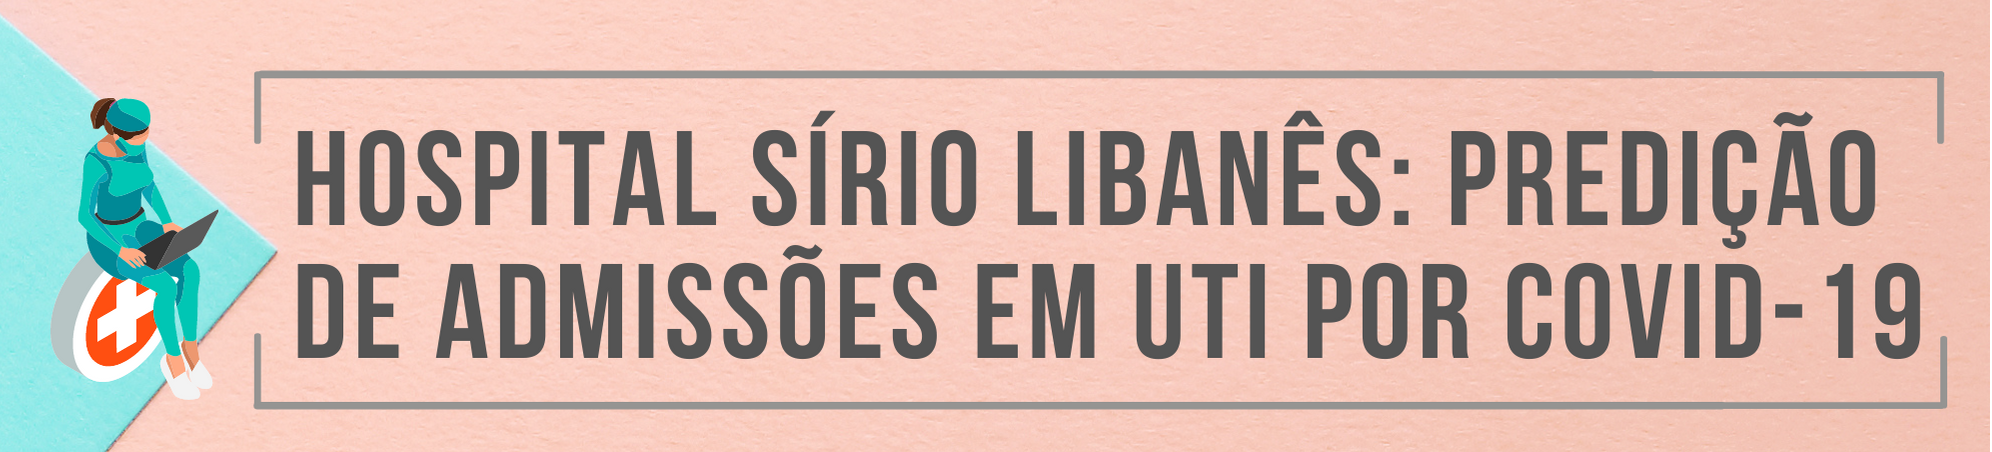

# RESUMO

## Sobre a COVID-19

Na primeira semana de Dezembro de 2019 uma doença desconhecida chama a atenção  em Wuhan, na China. 
Sintomas de pneumonia são detectados em pacientes e a doença evolui rapidamente, sendo a primeira morte confirmada em 9 de Janeiro de 2020. Inicia-se, ali, uma corrida contra o tempo para evitar que ela se torna-se um mal maior se espalhando para outros habitantes da cidade. Mas já era tarde. 

Além de avançar pela cidade, a doença avançou pela China e, depois, pelo mundo, levando à uma tragédia anunciada. Causada por um vírus desconhecido, pegou governos despreparados para uma batalha desleal. A Itália, já em 2020, é um exemplo disso, já que sofreu uma avalanche de casos e mortes pela COVID-19 e teve de utilizar veículos militares para transporte de corpos.

O primeiro caso de COVID-19 no Brasil foi anunciado pelo Ministério da Saúde no dia 26 de Fevereiro de 2020, na cidade de São Paulo, sendo o paciente homem de 61 um anos com passagem pela Itália. Desde então o número de casos por aqui subiu a ladeira a se perder de vista, até certa estabilidade entre Agosto/2020 e Novembro/2020, quando se pensou que o pior já teria passado. Mas aí chegou 2021...

Em 2021 chegamos a números avassaladores com média móvel acima de 3000 mortos por dia, chegando, em certos dias, a quase 4000 mortos. Fatores como maus exemplos políticos, demora nas compras de vacinas e desleixo do próprio povo que quebrava o isolamento para festas e baladas nos levaram a números de guerra. 

A maioria das pessoas das gerações atuais não imaginava passar por algo assim, mesmo que a última pandemia tenha sido ainda no século passado. Sim, a gripe espanhola não está tão longe assim! Além disso, cientistas alertam que essa não será a última pandemia. E isso nos leva a refletir sobre um ponto obscuro em relação ao futuro: se quase 300.000 mortos, em 1 ano, não fazem um povo refletir sobre empatia e responsabilidade com o próximo, o que fará?

## Sobre o projeto

Nesse projeto vamos fazer uma análise geral do dataset em questão para melhor entendimento dos dados, através de medidas estatísticas apropriadas e gráficos que nos levem à uma convergência de pensamento para melhor modelagem dos dados.

Após as análises iniciais poderemos fazer a preparação dos dados para utilização de modelos de Machine Learning para o objetivo principal: fazer a predição de quais pacientes necessitarão de internação em UTIs. Assim, o hospital poderá se preparar melhor em relação à quantidade de leitos e equipamentos necessários para melhor atendimento desses pacientes.

## Link do dataset

* https://www.kaggle.com/S%C3%ADrio-Libanes/covid19

# IMPORTS E FUNÇÕES AUXILIARES

## Imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
warnings.filterwarnings('ignore')

## Funções Auxiliares

### Criação de tabelas de frequência

In [15]:
def criar_tabela_de_frequencia(dados):
    dist_freq = pd.DataFrame(dados.value_counts())
    dist_freq.columns = ['freq']
    dist_freq['freq_relativa'] = (dados.value_counts(normalize = True)*100).round(3)
    
    return dist_freq

In [16]:
def criar_tabela_de_frequencia_com_nomes(dados, nomes_index):
    dist_freq = pd.DataFrame(dados.value_counts())
    dist_freq.columns = ['freq']
    dist_freq['freq_relativa'] = (dados.value_counts(normalize = True)*100)
    dist_freq.index = nomes_index
    
    return dist_freq

### prepara_window

In [17]:
def prepara_window(dados_agrupados):
    #dados_agrupados.groupby('PATIENT_VISIT_IDENTIFIER')
    if (np.any(dados_agrupados['ICU'])): # se qualquer uma das 5 linhas do paciente for True (valor 1), 
        # satisfaz a condição
        dados_agrupados.loc[dados_agrupados['WINDOW'] == '0-2', 'ICU'] = 1 #localiza a primeira linha 
        # (primeira janela) e insere o valor 1 na coluna ICU, caso a condição seja satisfeita
    return dados_agrupados.loc[dados_agrupados['WINDOW'] == '0-2'] # retorna apenas a primeira linha de 
    # cada paciente

### Gráficos

#### Gráfico de barras e pizza lado a lado

In [18]:
def grafico_barras_pizza(dados, titulo_barra, xlabel, ylabel, titulo_pizza):
    plt.subplots(figsize=(20,5))
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                      wspace=0.5, hspace=0.2)
    
    plt.subplot(131)

    ax1 = sns.countplot(dados)
    ax1.set_title(titulo_barra, pad = 20, size = 16)
    ax1.set_xlabel(xlabel, size = 14)
    ax1.set_ylabel(ylabel, size = 14)
    #ax1.set_xticklabels(size = 10)
    ax1.grid()
    
    for p in ax1.patches:
        ax1.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
    
    plt.subplot(132)
    labels = dados.value_counts().index
    plt.pie(dados.value_counts(), autopct = '%1.1f%%', explode = (0.015,0.015), labels=labels)
    plt.title(titulo_pizza, size = 16)

#### Gráfico de pizza

In [19]:
def grafico_pizza_porcentagens(df, titulo):
    plt.figure(figsize = (15,5))
    labels = df.index
    plt.pie(df, autopct = '%1.1f%%', explode = (0.015,0.015), labels = labels)
    plt.title(titulo)
    #df.plot(kind = 'pie', figsize = (15,5), legend = None, title = titulo, subplots = True, autopct = '%1.1f%%')
    plt.show()

#### Gráfico de barras horizontal

In [20]:
def grafico_barras_horizontal(df, titulo):
    sns.barplot(x = df.values, y = df.index)
    plt.title(titulo, pad = 20, fontsize = 14)
    plt.grid()

### Modelo - Treinamento e predição

#### RepeatedStratifiedKFold

A função abaixo foi criada para fazer a separação dos dados em treino e teste, a validação cruzada, o treinamento e a avaliação do modelo.

In [21]:
def roda_modelo_repeat_cv(modelo, dados, n_splits, n_repeats):
    
    np.random.seed(1425)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    X = dados[x_columns].drop(['ICU', 'WINDOW'], axis = 1)
    y = dados['ICU']
    
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    resultado_cv = cross_validate(modelo, X, y, cv = cv, scoring = 'roc_auc')
    
    auc_media = np.mean(resultado_cv['test_score'])
    desvio_padrao = np.std(resultado_cv['test_score'])
    intervalo_de_confianca_abaixo = auc_media - (2 * desvio_padrao)
    intervalo_de_confianca_acima = auc_media + (2 * desvio_padrao )   
    
    print(f'AUC médio: {auc_media}')
    print(f'Desvio-padrão médio: {desvio_padrao}')
    print(f'Intervalo de confiança da acurácia: {intervalo_de_confianca_abaixo} à {intervalo_de_confianca_acima}')    
    
    return auc_media

### Estilização de DataFrame

In [22]:
def cor_df(val):
    yellow = 'background-color: #4682B4' if val > .75 else ''
    return yellow

### Determinar janela de internação

In [23]:
# função para encontrarmos a primeira janela, de cada paciente, aonde há o valor 1 na coluna ICU
def encontrar_janela_de_internacao(dados):
    janela_de_internacao = []
    pacientes_na_uti = dados.query('ICU == 1')[['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU']]
    id_paciente_na_uti = pacientes_na_uti['PATIENT_VISIT_IDENTIFIER'].unique()
    for identificacao in id_paciente_na_uti:
        janela_de_internacao.append(pacientes_na_uti[pacientes_na_uti['PATIENT_VISIT_IDENTIFIER'] == identificacao]['WINDOW'].min()) 

    df_janela_de_internacao = pd.DataFrame(janela_de_internacao)
    df_janela_de_internacao.columns = ['janela_internacao']
    
    return df_janela_de_internacao

### Exclusão de variáveis com alta correlação

In [24]:
def remove_corr_var(dados, valor_corte):
    matriz_corr = dados.iloc[:, 4:-2].corr().abs()
    matriz_corr_nova = matriz_corr.where(np.triu(np.ones(matriz_corr.shape), k = 1).astype(np.bool))
    excluir = [coluna for coluna in matriz_corr_nova.columns if any(matriz_corr_nova[coluna] > valor_corte)]
    
    return dados.drop(excluir, axis = 1)

# CARREGAMENTO DOS DADOS E EXPLORAÇÃO BÁSICA

In [25]:
dados = pd.read_excel('Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

## Sobre os dados

In [26]:
# número de linhas e colunas
print(f'Número de linhas: {dados.shape[0]}')
print(f'Número de colunas: {dados.shape[1]}')

Número de linhas: 1925
Número de colunas: 231


In [27]:
# informações básicas sobre o dataset
print('Informações do dataset e tipos de dados:\n')

dados.info()

Informações do dataset e tipos de dados:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


In [28]:
# linhas aleatórias do dataset
print('Verificação de algumas linhas do dataset:')

dados.sample(8)

Verificação de algumas linhas do dataset:


,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
1548,309,0,40th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0
1395,279,0,50th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
462,92,0,10th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
952,190,1,60th,1,1.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
1617,323,0,40th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
983,196,0,20th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-12,0
178,35,0,30th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.857143,-0.939394,-1.000000,-0.869128,-0.955165,-0.794355,-0.860232,-0.939447,6-12,0
1344,268,0,20th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.428571,-0.858586,-0.513996,-0.257596,-0.673210,-0.695341,-0.430146,-0.858709,ABOVE_12,0


## Variáveis categóricas

### Variáveis object

In [29]:
# variáveis do tipo object
dados.select_dtypes('object').columns

Index(['AGE_PERCENTIL', 'WINDOW'], dtype='object')

In [30]:
# valores das variáveis "object"
display(pd.DataFrame(dados['AGE_PERCENTIL'].sort_values().unique()).T)
display(pd.DataFrame(dados['WINDOW'].sort_values().unique()).T)

,0,1,2,3,4,5,6,7,8,9
0,10th,20th,30th,40th,50th,60th,70th,80th,90th,Above 90th


,0,1,2,3,4
0,0-2,2-4,4-6,6-12,ABOVE_12


### Variáveis inteiras

Precisamos conhecer os valores das variáveis categóricas, representadas por números inteiros, para entendermos quais categorias representam.

In [31]:
# colunas do tipo int64
dados.select_dtypes('int64').columns

Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'GENDER', 'ICU'], dtype='object')

Valores das variáveis inteiras

In [32]:
# 'PATIENT_VISIT_IDENTIFIER'
dados['PATIENT_VISIT_IDENTIFIER'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [33]:
# 'AGE_ABOVE65'
dados['AGE_ABOVE65'].sort_values().unique()

array([0, 1], dtype=int64)

In [34]:
# 'GENDER'
dados['GENDER'].sort_values().unique()

array([0, 1], dtype=int64)

In [35]:
# 'ICU'
dados['ICU'].sort_values().unique()

array([0, 1], dtype=int64)

### Resumo estatístico das variáveis float

In [36]:
dados.describe(include = 'float')

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,...,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,821.000000,...,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000
mean,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,0.158333,0.809896,0.528527,...,-0.754100,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982
std,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,0.365148,0.392485,0.224100,...,0.366349,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.605263,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.605263,...,-0.984733,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.605263,...,-0.541985,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Podemos perceber que as variáveis do tipo int64 são categóricas, pois representam categorias de idade, sexo, identificação do paciente e se ele foi parar, em algum momento, na UTI.

* AGE_ABOVE65 -> 1 == acima de 65 anos
* ICU -> 1 == internado na UTI

# ANÁLISE EXPLORATÓRIA

### <ins><b>ICU</b></ins> -> Número de pacientes que foram internados e que não foram internados na UTI

In [37]:
# identificação de todos os pacientes que foram parar na UTI em algum momento através de seu identificador
# desta forma eliminamos os valores de ICU duplicados por janelas de tempo
id_uti = dados['PATIENT_VISIT_IDENTIFIER'][dados['ICU'] == 1].unique()
# pacientes que não foram parar na UTI
id_nao_uti = pd.Series(dados.query("PATIENT_VISIT_IDENTIFIER not in @id_uti")['PATIENT_VISIT_IDENTIFIER']).unique()    

In [38]:
df_uti = pd.DataFrame([len(id_uti), len(id_nao_uti)])
df_uti.index = ['foram para a UTI', 'não foram para a UTI']
df_uti.columns = ['Número de pacientes']
df_uti

,Número de pacientes
foram para a UTI,195
não foram para a UTI,190


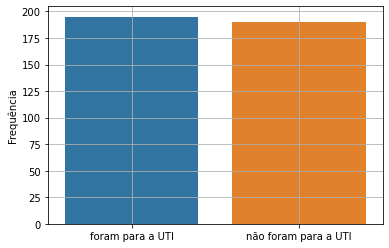

In [39]:
sns.barplot(data = df_uti, x = df_uti.index, y = 'Número de pacientes')
plt.ylabel('Frequência')
plt.grid();

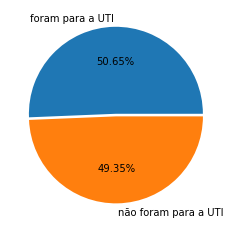

In [40]:
plt.pie(df_uti['Número de pacientes'], labels = df_uti.index, autopct='%.2f%%', explode = (0.015,0.015));

Podemos observar que pouco mais da metade dos pacientes necessitaram de internação na UTI, número compreendido por 50,65% destes. Isso reforça a necessidade de preparação antecipada por parte do hospital em relação a leitos e equipamentos.

### <ins><b>ICU</b></ins> -> Número de pacientes, por gênero, que foram internados na UTI

Vamos gerar gráficos para que possamos entender melhor os números relacionados à UTI de acordo com o gênero dos pacientes. Lembrando que, através da anonimação dos dados, não possuímos a descrição dos gêneros, para que seja mantida sua privacidade.

In [41]:
# total de pacientes da amostra, por gênero
total_pacientes_por_genero = dados[dados['WINDOW'] == '0-2']['GENDER']

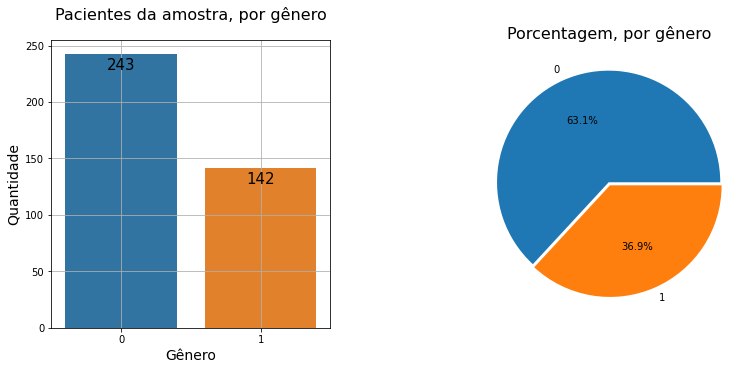

In [42]:
# gráfico com o gênero dos pacientes da amostra
grafico_barras_pizza(total_pacientes_por_genero, 'Pacientes da amostra, por gênero', 'Gênero', 'Quantidade', 'Porcentagem, por gênero')

In [43]:
# gênero dos pacientes que foram parar na UTI
genero_uti = dados.query('(PATIENT_VISIT_IDENTIFIER in @id_uti) & (WINDOW == "0-2")')['GENDER']
genero_nao_uti = dados.query('(PATIENT_VISIT_IDENTIFIER in @id_nao_uti) & (WINDOW == "0-2")')['GENDER']

Acima vemos que 63,1% do **total de pacientes** da <b>amostra</b> são do sexo 0.

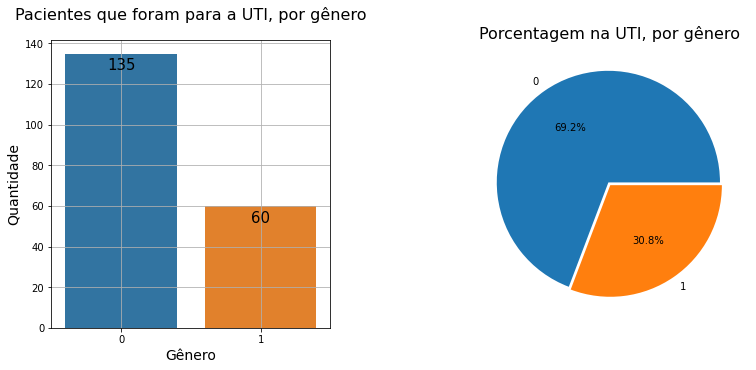

In [44]:
# gráfico dos pacientes que foram para a UTI, por gênero
grafico_barras_pizza(genero_uti, 'Pacientes que foram para a UTI, por gênero', 'Gênero', 'Quantidade', 'Porcentagem na UTI, por gênero')

O gráfico acima nos mostra que o gênero "0" teve mais do que o dobro de pacientes internados, em algum momento, na UTI. 

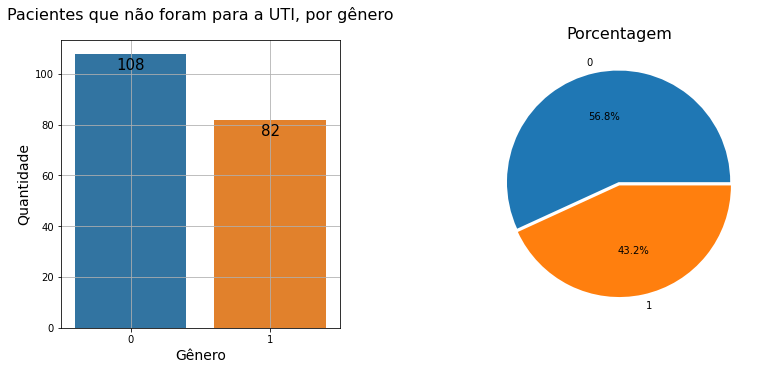

In [45]:
grafico_barras_pizza(genero_nao_uti, 'Pacientes que não foram para a UTI, por gênero', 'Gênero', 'Quantidade', 'Porcentagem')

Temos um equilíbrio maior entre os gêneros em relação à pacientes que não foram para a UTI em nenhuma das janelas de tempo. 

Podemos utilizar os dados de cada gênero, separadamente, para que tenhamos noção da diferença desses números.

In [46]:
# pacientes do gênero "0"
genero_zero = dados.query("GENDER == 0")[['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU']]
# pacientes do genero 0 que foram para a UTI em algum momento
genero_zero = genero_zero.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepara_window).reset_index(drop = True)

In [47]:
# alteração dos valores de ICU
dic = {0: 'Não foram para a UTI',
      1: 'Foram para a UTI'}

genero_zero['ICU'] = genero_zero['ICU'].map(dic)

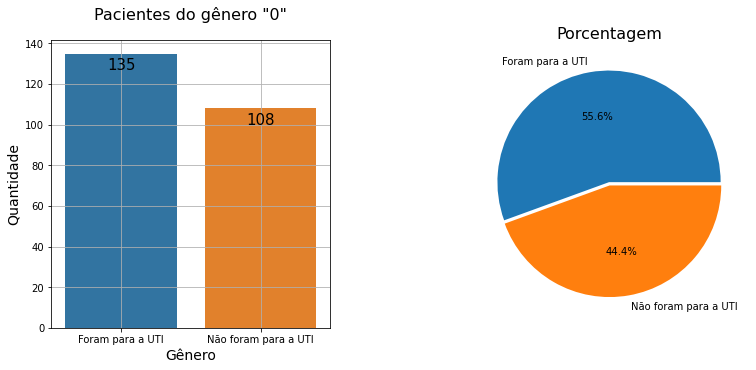

In [48]:
grafico_barras_pizza(genero_zero['ICU'], 'Pacientes do gênero "0"', 'Gênero', 'Quantidade', 'Porcentagem')

Percebemos nessas análises sobre o gênero que o determinado pelo número "0" teve 55,6% de seus pacientes internados, em alguma janela de tempo, na UTI.

In [49]:
# pacientes do gênero "0"
genero_um = dados.query("GENDER == 1")[['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU']]
# pacientes do genero 0 que foram para a UTI em algum momento
genero_um = genero_um.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepara_window)

In [50]:
#alteração dos valores de ICU
dic = {0: 'Não foram para a UTI',
      1: 'Foram para a UTI'}

genero_um['ICU'] = genero_um['ICU'].map(dic)

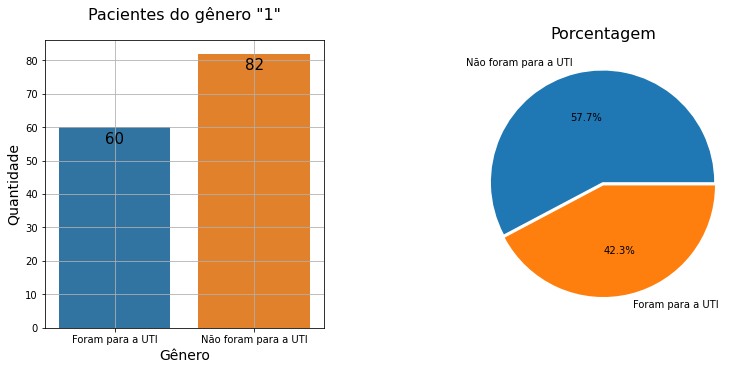

In [51]:
grafico_barras_pizza(genero_um['ICU'], 'Pacientes do gênero "1"', 'Gênero', 'Quantidade', 'Porcentagem')

Confrontando os dados de pacientes internados em UTI de cada gênero percebemos que houve uma porcentagem menor de pacientes do sexo "1" internados na UTI (42%), contra 42% do sexo "0". 

### <ins><b>WINDOW</b></ins> -> Em qual janela de tempo houve mais entradas na UTI (primeiro registro do paciente na UTI)? 

In [52]:
janela_de_internacao = encontrar_janela_de_internacao(dados)

In [53]:
# distribuição de frequências das janelas de internação
dist_freq_janelas_internacao = criar_tabela_de_frequencia(janela_de_internacao)
dist_freq_janelas_internacao

,freq,freq_relativa
janela_internacao,,
ABOVE_12,65,33.333
4-6,40,20.513
0-2,32,16.410
6-12,31,15.897
2-4,27,13.846


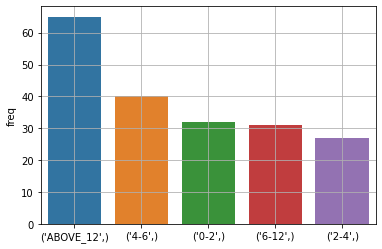

In [54]:
sns.barplot(data = dist_freq_janelas_internacao, x = dist_freq_janelas_internacao.index.values, 
            y = 'freq');
plt.grid()

A maior parte dos 195 pacientes que necessitaram de internação em UTI foram instalados em seus leitos na última janela de tempo do conjunto de dados, após mais de 12 horas de chegada no hospital.

Chama a atenção o número de pacientes internados na UTI na primeira janela de tempo, de até 2 horas após a chegada no hospital. Foram 32 pacientes nessa janela.

### <ins><b>DISEASE GROUPING</b></ins> -> Quais agrupamentos de doenças mais aparecem em pessoas que vão para a UTI?

In [55]:
# nomes de todas as colunas do dataset
lista_de_colunas = dados.columns.values

In [56]:
# apenas as colunas que representam agrupamentos de doenças
lista = [coluna for coluna in lista_de_colunas if coluna.startswith('DISEASE')]

In [57]:
dados[lista].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DISEASE GROUPING 1  1920 non-null   float64
 1   DISEASE GROUPING 2  1920 non-null   float64
 2   DISEASE GROUPING 3  1920 non-null   float64
 3   DISEASE GROUPING 4  1920 non-null   float64
 4   DISEASE GROUPING 5  1920 non-null   float64
 5   DISEASE GROUPING 6  1920 non-null   float64
dtypes: float64(6)
memory usage: 90.4 KB


In [58]:
dados[lista].describe()

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875
std,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
# pessoas que foram para a UTI
foram_para_uti = dados.query("ICU == 1")

In [60]:
# quantidade de registros confirmados para cada agrupamento de doenças
i = 0
agrupamentos_confirmados = {}
for coluna in lista:
    agrupamentos_confirmados[coluna] = foram_para_uti[lista[i]].value_counts()[1]
    i = i + 1

In [61]:
labels = list(agrupamentos_confirmados.keys())
valores = list(agrupamentos_confirmados.values())

# criação de dataframe para facilitar a ordenação dos valores
df_agrupamentos_confirmados = pd.DataFrame(list(agrupamentos_confirmados.values()),
                                           list(agrupamentos_confirmados.keys()))
df_agrupamentos_confirmados.columns = ['freq']
soma = df_agrupamentos_confirmados['freq'].sum()
df_agrupamentos_confirmados['freq_relativa'] = ((df_agrupamentos_confirmados['freq'] / soma) * 100).round(2)
df_agrupamentos_confirmados.sort_values(by = 'freq', ascending = False, inplace = True)

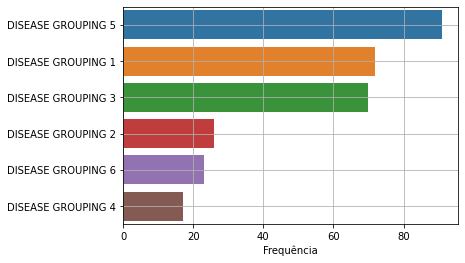

In [62]:
sns.barplot(x = df_agrupamentos_confirmados.freq, y = df_agrupamentos_confirmados.index)
plt.xlabel('Frequência')
plt.grid()
plt.show()

In [63]:
soma = pd.DataFrame([df_agrupamentos_confirmados.iloc[[0,1,2]].sum()['freq_relativa'], 
       (df_agrupamentos_confirmados.iloc[[3,4,5]].sum()['freq_relativa']).round(2)])
soma.index = ['DISEASE GROUPINGS 5, 1, 3', 'DISEASE GROUPINGS 2, 6, 4']
soma.columns = ['PORCENTAGEM']
soma.PORCENTAGEM

DISEASE GROUPINGS 5, 1, 3    77.92
DISEASE GROUPINGS 2, 6, 4    22.08
Name: PORCENTAGEM, dtype: float64

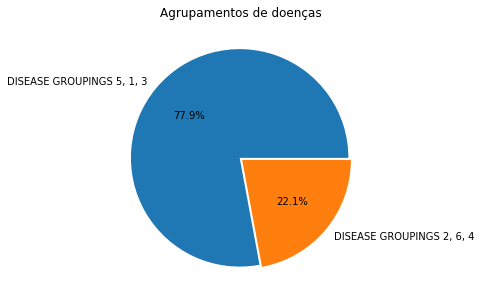

In [64]:
grafico_pizza_porcentagens(soma.PORCENTAGEM, 'Agrupamentos de doenças')

Apesar de não sabermos exatamente quais doenças pertencem a quais agrupamentos, podemos verificar que os agrupamentos 1, 3 e 5 correspondem a mais de 3/4 destes nos pacientes da amostra. Uma análise que pode ser feita posteriormente é a quantidade de pacientes que possuem tais doenças foram para a UTI em comparação aos pacientes que possuem as 3 doenças que representam menos de 1/4 destes nos pacientes da amostra.

### <ins><b>AGE_PERCENTIL</b></ins> -> Quais faixas de idade tiveram mais pacientes internados na UTI? Quantos pacientes acima de 65 anos?

In [65]:
# pegamos apenas a 1º janela de tempo do paciente que foi p/ a UTI p/ identificarmos a faixa de idade dele

age_percentil_uti = dados.query('(PATIENT_VISIT_IDENTIFIER in @id_uti) & (WINDOW == "0-2")')[['PATIENT_VISIT_IDENTIFIER','AGE_PERCENTIL', 'AGE_ABOVE65']]

#### Faixas com mais pacientes internados na UTI

In [66]:
# df com distribuições de frequência da faixa de idade dos pacientes que foram p/ UTI em algum momento

dist_freq_age_percentil = criar_tabela_de_frequencia(age_percentil_uti['AGE_PERCENTIL'])
dist_freq_age_percentil

,freq,freq_relativa
Above 90th,29,14.872
80th,26,13.333
90th,23,11.795
70th,22,11.282
50th,20,10.256
60th,20,10.256
30th,18,9.231
40th,15,7.692
20th,12,6.154
10th,10,5.128


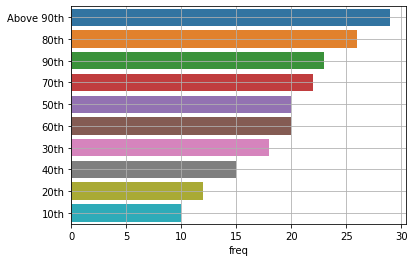

In [67]:
# grafico de barras

g = sns.barplot(data = dist_freq_age_percentil, x = 'freq', y = dist_freq_age_percentil.index)
plt.grid()

#### Pacientes acima dos 65 anos internados na UTI

In [68]:
# porcentagem acima de 65 anos e abaixo

uti_acima_65 = criar_tabela_de_frequencia(age_percentil_uti['AGE_ABOVE65'])
uti_acima_65.index = ['Acima de 65 anos', 'Abaixo de 65 anos']
uti_acima_65

,freq,freq_relativa
Acima de 65 anos,119,61.026
Abaixo de 65 anos,76,38.974


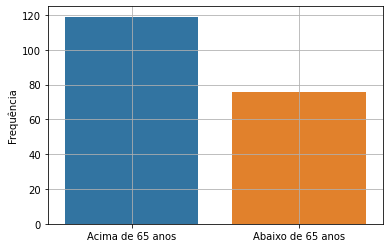

In [69]:
sns.barplot(data = uti_acima_65, x = uti_acima_65.index, y = 'freq')
plt.ylabel('Frequência')
plt.grid()
plt.show()

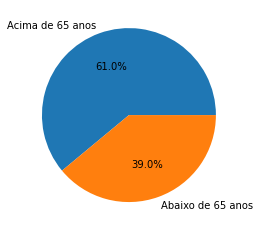

In [70]:
g = plt.pie(uti_acima_65.freq_relativa, autopct='%.1f%%', labels = uti_acima_65.index)
plt.show()

### <ins><b>AGE_PERCENTIL</b></ins> -> Quais faixas de idade tiveram mais pacientes internados na primeira janela? E na última?

#### Cópia do dataset e alteração das labels

In [71]:
dados_copia = dados.copy()

In [72]:
dados_copia.WINDOW.unique()

array(['0-2', '2-4', '4-6', '6-12', 'ABOVE_12'], dtype=object)

In [73]:
# vamos substituir as labels da coluna WINDOW por números inteiros, para facilitar a seleção
dic = {'0-2': 1, 
       '2-4': 2, 
       '4-6': 3, 
       '6-12': 4, 
       'ABOVE_12': 5}

In [74]:
# aplicação do dicionário de números
dados_copia.WINDOW = dados_copia.WINDOW.map(dic)

In [75]:
dados_copia.WINDOW.unique()

array([1, 2, 3, 4, 5], dtype=int64)

#### Pacientes que foram internados na UTI já na primeira janela

In [76]:
# passo_um -> pegamos o id do paciente que não foi p/ a UTI até a janela 6-12 e enviamos para um array
# passo_dois -> pegamos todas as linhas desses pacientes
# passo_tres -> dos pacientes que não foram p/ UTI até a janela 6-12, verificamos os que foram na ABOVE_12

#passo_um = dados_copia[(dados_copia['WINDOW'] == 1) & (dados_copia['ICU'] == 1)]['PATIENT_VISIT_IDENTIFIER'].unique()  
passo_um = dados_copia.query('WINDOW == 1 & ICU == 1')['PATIENT_VISIT_IDENTIFIER'].values

In [77]:
# pegamos a identificação dos pacientes que foram internados na UTI na primeira janela de tempo
#uti_0_2 = passo_um['PATIENT_VISIT_IDENTIFIER'].values
uti_0_2 = dados_copia.query('PATIENT_VISIT_IDENTIFIER in @passo_um')

#### Pacientes que foram internados UTI na última janela

In [78]:
# passo_um -> pegamos o id do paciente que não foi p/ a UTI até a janela 6-12 e enviamos para um array
# passo_dois -> pegamos todas as linhas desses pacientes
# passo_tres -> dos pacientes que não foram p/ UTI até a janela 6-12, verificamos os que foram na ABOVE_12
#passo_um = dados_copia.query('WINDOW == 5 & ICU == 1')
passo_um = dados_copia[(dados_copia['WINDOW'] == 4) & (dados_copia['ICU'] == 0)]['PATIENT_VISIT_IDENTIFIER'].unique()
passo_dois = dados_copia.query('PATIENT_VISIT_IDENTIFIER in @passo_um')
passo_tres = passo_dois[(passo_dois['WINDOW'] == 5) & (passo_dois['ICU'] == 1)]['PATIENT_VISIT_IDENTIFIER'].unique()

In [79]:
# pegamos a identificação dos pacientes que foram internados na UTI apenas na última janela de tempo
#uti_above_12 = passo_um['PATIENT_VISIT_IDENTIFIER'].values
uti_above_12 = dados_copia.query('PATIENT_VISIT_IDENTIFIER in @passo_tres')
#uti_above_12 = uti_above_12['PATIENT_VISIT_IDENTIFIER'].unique()

In [80]:
#inserindo novamente as labels das janelas de tempo
dic = {1: '0-2', 
       2: '2-4', 
       3: '4-6', 
       4: '6-12', 
       5: 'ABOVE_12'}

uti_0_2['WINDOW'], uti_above_12['WINDOW'] = uti_0_2['WINDOW'].map(dic), uti_above_12['WINDOW'].map(dic)

In [81]:
uti_0_2

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
5,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
6,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,1
7,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,1
8,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880952,-1.000000,-0.906832,-0.831132,-0.940967,-0.817204,-0.882574,-1.000000,6-12,1
9,1,1,90th,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,ABOVE_12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,379,1,Above 90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.959596,-0.799034,-0.796630,-0.937704,-0.846962,-0.976483,-0.961262,0-2,1
1896,379,1,Above 90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,1
1897,379,1,Above 90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,1
1898,379,1,Above 90th,1,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.833333,-0.979798,-0.764376,-0.441335,-0.935433,-0.746898,-0.835380,-0.980631,6-12,1


#### Gráficos

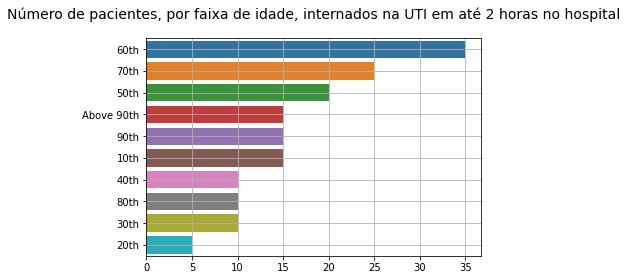

In [82]:
grafico_barras_horizontal(uti_0_2['AGE_PERCENTIL'].value_counts(),
                          'Número de pacientes, por faixa de idade, internados na UTI em até 2 horas no hospital')

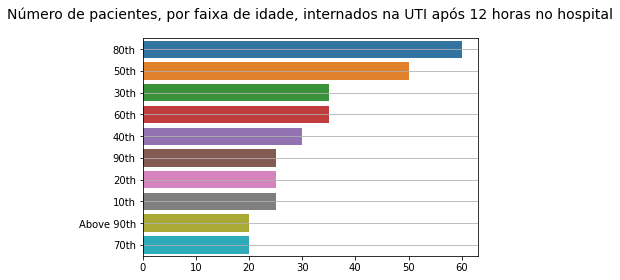

In [83]:
# ultima janela
ult_janela = uti_above_12['AGE_PERCENTIL'].value_counts()
#prim_janela.index
sns.barplot(x = ult_janela.values, y = ult_janela.index)
plt.grid()
grafico_barras_horizontal(uti_above_12['AGE_PERCENTIL'].value_counts(),
                          'Número de pacientes, por faixa de idade, internados na UTI após 12 horas no hospital')

# TRATAMENTO E PREPARAÇÃO DOS DADOS

## Valores Missing e remoção de dados

In [84]:
# verificando valores missing 

nulos = dados.isna().sum()
nulos.values

array([   0,    0,    0,    0,    5,    5,    5,    5,    5,    5,    5,
          5,    5, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104,
       1104, 1104, 1104, 1104, 1104, 1104, 1104, 11

Podemos perceber acima que praticamente todas as colunas do dataset possuem valores nulos.

Uma estratégia para preencher valores nulos das variáveis contínuas é utilizar o valor da linha anterior ou da linha posterior. Ou seja, se houver valor missing, vamos preencher com o valor da linha posterior. Caso não haja valor na linha posterior, será com o valor da linha anterior.

Um cuidado que temos que ter é agrupar os dados pela identificação do paciente, para que uma linha com valor nulo de um paciente não seja preenchida com o valor de outro paciente.

In [85]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


In [86]:
dados.select_dtypes('object').head(1)

,AGE_PERCENTIL,WINDOW
0,60th,0-2


In [87]:
dados.select_dtypes('int64').head(1)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,ICU
0,0,1,0,0


In [88]:
dados.select_dtypes('float64').columns

Index(['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MEDIAN',
       ...
       'HEART_RATE_DIFF', 'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF',
       'OXYGEN_SATURATION_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF_REL',
       'BLOODPRESSURE_SISTOLIC_DIFF_REL', 'HEART_RATE_DIFF_REL',
       'RESPIRATORY_RATE_DIFF_REL', 'TEMPERATURE_DIFF_REL',
       'OXYGEN_SATURATION_DIFF_REL'],
      dtype='object', length=225)

As colunas referentes a agrupamentos de doenças e as colunas 'HTN', 'IMMUNOCOMPROMISED', 'OTHER' são do tipo float64, porém são categóricas, possuindo apenas os valores 0 e 1. Essas colunas estão ordenadas no dataframe e são precedidas de outras 4 colunas que não são contínuas: PATIENT_VISIT_IDENTIFIER, AGE_ABOVE65, GENDER e ICU.

Sendo assim, podemos iniciar a seleção das variáveis contínuas a partir da coluna 13 (posição da coluna ALBUMIN_MEDIAN, primeira após OTHER) até as duas últimas colunas, WINDOW e ICU.

In [89]:
# criar função para preencher as colunas contínuas de acordo com o que foi decidido
# capturar features categóricas
# capturar, como saída, a janela e ICU
# concatenar (na mesma ordem, ignorando o índice e indicando o eixo) e retornar
def preenche_valores_nulos(dados):
    variaveis_continuas_colunas = dados.iloc[:, 13:-2].columns
    variaveis_continuas = dados.groupby('PATIENT_VISIT_IDENTIFIER')[variaveis_continuas_colunas].fillna(method = 'ffill').fillna(method = 'bfill')       
    saida = dados[['WINDOW', 'ICU']]
    variaveis_categoricas = dados.iloc[:, :13]
    dados_sem_nulos = pd.concat([variaveis_categoricas, variaveis_continuas, saida], ignore_index=True,
                                axis = 1)
    dados_sem_nulos.columns = dados.columns

    return dados_sem_nulos

In [90]:
dados_limpos = preenche_valores_nulos(dados).reset_index()

In [91]:
# identificação dos pacientes que foram para a UTI na primeira janela
a_remover = dados[(dados['WINDOW'] == "0-2") & dados['ICU'] == 1]['PATIENT_VISIT_IDENTIFIER'].values
a_remover

array([  1,  17,  27,  41,  47,  48,  54,  62,  85,  90, 104, 106, 109,
       117, 144, 176, 202, 206, 226, 233, 239, 261, 270, 282, 286, 306,
       315, 329, 359, 362, 366, 379], dtype=int64)

In [92]:
# fazendo a remoção 
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")

Queremos agora excluir o restante dos dados NA e depois os pacientes que já foram para a UTI na primeira janela de horas.

In [93]:
dados_limpos = dados_limpos.dropna()

## Mais algumas exclusões

Queremos deixar apenas uma linha por paciente, dizendo se ele foi para a UTI ou não.

Na primeira linha (primeira janela) será inserido o valor 1 na coluna ICU se o paciente, em qualquer janela, foi parar na UTI.

* A função utilizada faz o seguinte:
    - busca se naquele grupo de linhas (que serão agrupadas por paciente) há o valor 1 na coluna 'ICU'
    - se houver esse valor em qualquer uma das linhas, marca 1 na primeira linha do paciente
    - devolve a primeira linha de todos os pacientes. Aqueles que não foram para a UTI em nenhum momento terão valor 0 nessa linha

* O resultado será:
    - teremos uma linha por paciente, com os dados da primeira janela e com a coluna ICU preenchida com 0 se o paciente NÃO foi parar na UTI e 1 se ele FOI parar na UTI em qualquer outra   janela

In [94]:
dados_limpos = dados_limpos.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepara_window)

In [95]:
dados_limpos

,,index,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
5,25,25,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1900,1900,380,0,40th,1,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
381,1905,1905,381,1,Above 90th,0,0.0,0.0,0.0,0.0,0.0,...,-0.619048,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0-2,0
382,1910,1910,382,0,50th,0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1


## Alteração de AGE_PERCENTIL

Será importante transformarmos a variável AGE_PERCENTIL em categórica para utilização no modelo.

In [96]:
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype('category').cat.codes
dados.AGE_PERCENTIL = dados.AGE_PERCENTIL.astype('category').cat.codes

# DADOS CORRELACIONADOS - PRIMEIRA ABORDAGEM

## Alta correlação

O dataset possui 231 colunas. Será que todas são necessárias?

Na realidade, quanto mais labels no dataset, mais suscetível à overfitting o nosso modelo estará.

Uma das formas de escolhermos as melhores labels para o modelo é verificar a correlação entre elas. Podemos, por exemplo, remover as labels independentes com alta correlação com a label target/dependente, pois elas podem levar ao overfitting.

In [97]:
# gerar matriz de correlação
dados_limpos.corr()

,index,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
index,1.000000,1.000000,-0.017361,0.031159,0.071961,0.058683,0.022828,0.045907,-0.026074,-0.005678,...,-0.046410,-0.045353,-0.018859,-0.051978,-0.080779,-0.059587,-0.030755,-0.045456,-0.015996,-0.041382
PATIENT_VISIT_IDENTIFIER,1.000000,1.000000,-0.017361,0.031159,0.071961,0.058683,0.022828,0.045907,-0.026074,-0.005678,...,-0.046410,-0.045353,-0.018859,-0.051978,-0.080779,-0.059587,-0.030755,-0.045456,-0.015996,-0.041382
AGE_ABOVE65,-0.017361,-0.017361,1.000000,0.874773,0.031830,0.280326,0.051308,0.165905,0.032608,0.314536,...,-0.005558,0.028262,-0.030515,0.009262,-0.039387,0.002790,-0.021190,0.029317,-0.031404,0.291010
AGE_PERCENTIL,0.031159,0.031159,0.874773,1.000000,0.056211,0.294671,0.058015,0.134016,0.014480,0.334920,...,-0.007992,-0.006030,-0.040314,0.013580,-0.062474,-0.037260,-0.040807,-0.004185,-0.039724,0.351071
GENDER,0.071961,0.071961,0.031830,0.056211,1.000000,0.036528,-0.001784,-0.064757,-0.069768,-0.019812,...,-0.016903,-0.012423,0.028744,-0.011922,-0.021507,0.074222,-0.014353,-0.011416,0.029412,-0.117938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HEART_RATE_DIFF_REL,-0.059587,-0.059587,0.002790,-0.037260,0.074222,0.093512,0.005102,-0.011633,-0.034997,-0.045113,...,0.320962,0.362021,0.360456,0.373031,0.418624,1.000000,0.343703,0.364743,0.350001,-0.004147
RESPIRATORY_RATE_DIFF_REL,-0.030755,-0.030755,-0.021190,-0.040807,-0.014353,-0.052568,-0.003487,-0.008895,0.023616,-0.058564,...,0.961739,0.316620,0.349747,0.349866,0.421228,0.343703,1.000000,0.313204,0.342852,0.077798
TEMPERATURE_DIFF_REL,-0.045456,-0.045456,0.029317,-0.004185,-0.011416,-0.039692,-0.024682,0.003183,0.034426,-0.080693,...,0.282514,0.999444,0.503937,0.356403,0.422108,0.364743,0.313204,1.000000,0.493818,-0.008514
OXYGEN_SATURATION_DIFF_REL,-0.015996,-0.015996,-0.031404,-0.039724,0.029412,-0.056984,0.099019,0.006110,-0.025072,-0.097014,...,0.325973,0.497784,0.998889,0.521889,0.479010,0.350001,0.342852,0.493818,1.000000,0.026663


Não faz sentido mantermos algumas colunas entre as que serão apresentadas ao modelo para treinamento. A coluna de identificação do paciente é um exemplo.

Podemos verificar melhor os tipos das colunas para verificar quais são numéricas e quais são categóricas.

In [98]:
# info
dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 352 entries, (0, 0) to (384, 1920)
Columns: 232 entries, index to ICU
dtypes: float64(225), int64(5), int8(1), object(1)
memory usage: 652.6+ KB


Ao que parece, os dados do tipo float são referentes aos exames e os do tipo inteiro são categóricos.

Podemos selecionar apenas essas colunas do tipo inteiro para verificarmos.

In [99]:
# selecionar, excluindo os dados float
dados_limpos.select_dtypes(exclude = 'float64')

,,index,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,
0,0,0,0,1,5,0,0-2,1
2,10,10,2,0,0,0,0-2,1
3,15,15,3,0,3,1,0-2,0
4,20,20,4,0,0,0,0-2,0
5,25,25,5,0,0,0,0-2,0
...,...,...,...,...,...,...,...,...
380,1900,1900,380,0,3,1,0-2,1
381,1905,1905,381,1,9,0,0-2,0
382,1910,1910,382,0,4,0,0-2,1


In [100]:
# correlação sem os dados float
cols = dados_limpos.select_dtypes(exclude = 'float64')
dados_limpos.drop(cols, axis = 1).corr().abs()

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,...,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
DISEASE GROUPING 1,1.000000,0.196347,0.278271,0.017529,0.340370,0.202849,0.489245,0.176224,0.153793,0.009174,...,0.129220,0.028964,0.041099,0.056287,0.050070,0.054745,0.093512,0.052568,0.039692,0.056984
DISEASE GROUPING 2,0.196347,1.000000,0.084392,0.114818,0.112878,0.032173,0.118516,0.139947,0.068432,0.032245,...,0.014222,0.001618,0.024705,0.085122,0.070419,0.016917,0.005102,0.003487,0.024682,0.099019
DISEASE GROUPING 3,0.278271,0.084392,1.000000,0.308875,0.293259,0.275760,0.471039,0.075599,0.141903,0.035719,...,0.015035,0.013900,0.000746,0.005011,0.004373,0.020683,0.011633,0.008895,0.003183,0.006110
DISEASE GROUPING 4,0.017529,0.114818,0.308875,1.000000,0.128287,0.171438,0.136472,0.103100,0.063919,0.049593,...,0.023554,0.016131,0.032550,0.026121,0.043714,0.029596,0.034997,0.023616,0.034426,0.025072
DISEASE GROUPING 5,0.340370,0.112878,0.293259,0.128287,1.000000,0.129836,0.459169,0.108849,0.149025,0.082353,...,0.011404,0.045482,0.081749,0.098081,0.017232,0.059434,0.045113,0.058564,0.080693,0.097014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLOODPRESSURE_SISTOLIC_DIFF_REL,0.054745,0.016917,0.020683,0.029596,0.059434,0.003571,0.009490,0.028020,0.040651,0.056603,...,0.371623,0.366943,0.425505,0.483904,0.779557,1.000000,0.418624,0.421228,0.422108,0.479010
HEART_RATE_DIFF_REL,0.093512,0.005102,0.011633,0.034997,0.045113,0.018891,0.073639,0.015522,0.064229,0.046781,...,0.949914,0.320962,0.362021,0.360456,0.373031,0.418624,1.000000,0.343703,0.364743,0.350001
RESPIRATORY_RATE_DIFF_REL,0.052568,0.003487,0.008895,0.023616,0.058564,0.049022,0.045665,0.019384,0.071270,0.029099,...,0.293907,0.961739,0.316620,0.349747,0.349866,0.421228,0.343703,1.000000,0.313204,0.342852
TEMPERATURE_DIFF_REL,0.039692,0.024682,0.003183,0.034426,0.080693,0.005691,0.031264,0.008243,0.018162,0.061337,...,0.298203,0.282514,0.999444,0.503937,0.356403,0.422108,0.364743,0.313204,1.000000,0.493818


Variáveis altamente correlacionadas são aquelas que se aproximam muito de -1 (correlação negativa ou inversa) e de 1 (correlação positiva).

Vamos remover essas variáveis com alta correlação com a variávei target.

In [101]:
# valor da alta correlação
alta_corr = 0.95

In [102]:
# criar matriz de correlação com numeros absolutos, sem as colunas categóricas e object
# remover as colunas float, inseridas na variável "cols"
matriz_corr = dados_limpos.drop(cols, axis = 1).corr().abs()

In [103]:
# utilizar função any para encontrar colunas com 
# uma lista chamada "coluna" recebe as colunas acima do valor de alta_corr
excluir = [coluna for coluna in matriz_corr.columns if any(matriz_corr[coluna] > alta_corr)]
len(excluir)

189

O que aconteceu é que a lista recebeu todas as colunas do dataset, pois todas as colunas tem alta correlação com elas mesma (1.0000, obviamente).

Outra situação que pode ocorrer: podemos perceber abaixo, na matriz de correlação, que os valores 1.0000, de correlação de uma variável com ela mesma, formam uma divisão diagonal que possui dois "triângulos", um de cada lado. É como se fosse um espelho de comparação entre as variáveis.

Sendo assim, a matriz mostra, por exemplo, uma mesma correlação 2 vezes, vista do ângulo de cada uma das 2 variáveis. Esse fato levaria à exclusão das 2 variáveis.

Ex: (AGE_ABOVE65 & AGE_PERCENTIL == 0.874773) -> (AGE_PERCENTIL & AGE_ABOVE65 == 0.874773)

Precisamos de uma solução que não faça essa dupla exclusão.

In [104]:
# criar matriz de ones
# essa matriz possui os "dois triângulos", como na matriz de correlação
np.ones(matriz_corr.shape)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [105]:
# recriar a matriz de ones, eliminando o triangulo diagonal de baixo e a diagonal principal
# transformar em verdadeiros e falsos
np.triu(np.ones(matriz_corr.shape), k = 1).astype(np.bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

In [106]:
# aplicar à matriz de correlação utilizando a função where, criando nova variável
matriz_corr_nova = matriz_corr.where(np.triu(np.ones(matriz_corr.shape), k = 1).astype(np.bool))

In [107]:
# descobrir colunas com alta correlação
excluir = [coluna for coluna in matriz_corr_nova.columns if any(matriz_corr_nova[coluna] > alta_corr)]
len(excluir)

131

In [108]:
dados_limpos.iloc[:,4:-2].corr().abs()

,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,...,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
GENDER,1.000000,0.036528,0.001784,0.064757,0.069768,0.019812,0.020573,0.013136,0.026982,0.054201,...,0.079236,0.016903,0.012423,0.028744,0.011922,0.021507,0.074222,0.014353,0.011416,0.029412
DISEASE GROUPING 1,0.036528,1.000000,0.196347,0.278271,0.017529,0.340370,0.202849,0.489245,0.176224,0.153793,...,0.129220,0.028964,0.041099,0.056287,0.050070,0.054745,0.093512,0.052568,0.039692,0.056984
DISEASE GROUPING 2,0.001784,0.196347,1.000000,0.084392,0.114818,0.112878,0.032173,0.118516,0.139947,0.068432,...,0.014222,0.001618,0.024705,0.085122,0.070419,0.016917,0.005102,0.003487,0.024682,0.099019
DISEASE GROUPING 3,0.064757,0.278271,0.084392,1.000000,0.308875,0.293259,0.275760,0.471039,0.075599,0.141903,...,0.015035,0.013900,0.000746,0.005011,0.004373,0.020683,0.011633,0.008895,0.003183,0.006110
DISEASE GROUPING 4,0.069768,0.017529,0.114818,0.308875,1.000000,0.128287,0.171438,0.136472,0.103100,0.063919,...,0.023554,0.016131,0.032550,0.026121,0.043714,0.029596,0.034997,0.023616,0.034426,0.025072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLOODPRESSURE_SISTOLIC_DIFF_REL,0.021507,0.054745,0.016917,0.020683,0.029596,0.059434,0.003571,0.009490,0.028020,0.040651,...,0.371623,0.366943,0.425505,0.483904,0.779557,1.000000,0.418624,0.421228,0.422108,0.479010
HEART_RATE_DIFF_REL,0.074222,0.093512,0.005102,0.011633,0.034997,0.045113,0.018891,0.073639,0.015522,0.064229,...,0.949914,0.320962,0.362021,0.360456,0.373031,0.418624,1.000000,0.343703,0.364743,0.350001
RESPIRATORY_RATE_DIFF_REL,0.014353,0.052568,0.003487,0.008895,0.023616,0.058564,0.049022,0.045665,0.019384,0.071270,...,0.293907,0.961739,0.316620,0.349747,0.349866,0.421228,0.343703,1.000000,0.313204,0.342852
TEMPERATURE_DIFF_REL,0.011416,0.039692,0.024682,0.003183,0.034426,0.080693,0.005691,0.031264,0.008243,0.018162,...,0.298203,0.282514,0.999444,0.503937,0.356403,0.422108,0.364743,0.313204,1.000000,0.493818


In [109]:
# excluindo a alta correlação
novos_dados = remove_corr_var(dados_limpos, alta_corr)

In [110]:
dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 352 entries, (0, 0) to (384, 1920)
Columns: 232 entries, index to ICU
dtypes: float64(225), int64(5), int8(1), object(1)
memory usage: 652.6+ KB


# TREINAMENTO E AVALIAÇÃO DOS MODELOS - PRIMEIRA ABORDAGEM

Nesta seção iremos utilizar uma função criada para fazer a separação, validação cruzada e treinamento dos modelos, além de mostrar a avaliação dos mesmos através de funções de métricas fornecidas pelo pacote "sklearn".

## Função

A função abaixo utiliza a função RepeatedStratifiedKFold(). Ela repete o processo de divisão dos dados visto em KFold com dados diferentes em cada repetição. O número de repetições pode ser escolhido. 

A função RepeatedStratifiedKFold() também mantém a estratificação dos dados, ou seja, a proporção de cada amostra da variável target em cada iteração.

Essa função será utilizada para treinamento e avaliação de alguns modelos para predição de pacientes que irão ou não para a UTI. Ela está contida dentro de outra função, a roda_modelo_repeat_cv(), incluída na seção de "Funções auxiliares", subseção "Modelo - Treinamento e predição".

## Instanciação dos modelos

In [111]:
modelo_logistic_regression = LogisticRegression()
modelo_decision_tree = DecisionTreeClassifier()
modelo_svc = SVC()
modelo_random_forest = RandomForestClassifier()
modelo_knn = KNeighborsClassifier()

## Treinamento e avaliação

In [112]:
acuracia_logistic_regression = roda_modelo_repeat_cv(modelo_logistic_regression, novos_dados, 5, 10)

AUC médio: 0.7612414597611966
Desvio-padrão médio: 0.059377019065659925
Intervalo de confiança da acurácia: 0.6424874216298768 à 0.8799954978925164


In [113]:
acuracia_decision_tree = roda_modelo_repeat_cv(modelo_decision_tree, novos_dados, 5, 10)

AUC médio: 0.6345163988749516
Desvio-padrão médio: 0.07210239877223164
Intervalo de confiança da acurácia: 0.49031160133048834 à 0.7787211964194148


In [114]:
acuracia_svc = roda_modelo_repeat_cv(modelo_svc, novos_dados, 5, 10)

AUC médio: 0.5590769672184145
Desvio-padrão médio: 0.0855856551650252
Intervalo de confiança da acurácia: 0.3879056568883641 à 0.7302482775484649


In [115]:
acuracia_random_forest = roda_modelo_repeat_cv(modelo_random_forest, novos_dados, 5, 10)

AUC médio: 0.8052887449351265
Desvio-padrão médio: 0.04720071317171027
Intervalo de confiança da acurácia: 0.710887318591706 à 0.899690171278547


In [116]:
acuracia_knn = roda_modelo_repeat_cv(modelo_knn, novos_dados, 5, 10)

AUC médio: 0.5221913188607267
Desvio-padrão médio: 0.057983575176642425
Intervalo de confiança da acurácia: 0.4062241685074418 à 0.6381584692140115


# DADOS CORRELACIONADOS  - SEGUNDA ABORDAGEM (CORRELAÇÃO ACIMA DE 0.1)

Nesta seção será feita uma abordagem um pouco diferente: vamos testar se a manutenção das variáveis que possuem maior correlação com a variável target pode trazer melhores resultados na acurácia dos modelos. Novamente, hiperparâmetros não terão seus valores alterados.

Serão consideradas as variáveis com correlação acima de 0.10, em valores absolutos, com a variável target.

As variáveis com alta correlação também serão removidas, da mesma forma como na primeira abordagem.

In [117]:
# selecionando as variáveis com maior correlação com ICU, em seus valores absolutos, maiores do que 0.1
importantes = dados_limpos.drop(['ICU', 'WINDOW'], axis=1).apply(lambda x: x.corr(dados_limpos.ICU))
absolutos = abs(importantes)
maiores = absolutos[absolutos > 0.1]

In [118]:
correlacao = dados_limpos[maiores.index]

In [119]:
def remove_corr_var(dados, valor_corte):
    matriz_corr = dados.corr()
    # a linha abaixo cria a matriz de ones, eliminando o triangulo diagonal de baixo e a diagonal principal
    # e transforma em verdadeiros e falsos
    matriz_corr_nova = matriz_corr.where(np.triu(np.ones(matriz_corr.shape), k = 1).astype(np.bool)) 
    excluir = [coluna for coluna in matriz_corr_nova.columns if any(matriz_corr_nova[coluna] > valor_corte)]           
    
    return dados.drop(excluir, axis = 1)

In [120]:
dados_correlacionados_ICU = remove_corr_var(correlacao, 0.95)

In [121]:
# alterando o formato da coluna "PATIENT_VISIT_IDENTIFIER" e corrigindo o indice
temp = dados_limpos.drop('PATIENT_VISIT_IDENTIFIER', axis = 1)
temp = temp.reset_index()
temp['PATIENT_VISIT_IDENTIFIER'] = dados_limpos.PATIENT_VISIT_IDENTIFIER.values
temp.drop(['level_1', 'index'], axis = 1)

dados_correlacionados_ICU = dados_correlacionados_ICU.reset_index()
dados_correlacionados_ICU['PATIENT_VISIT_IDENTIFIER'] = dados_limpos.PATIENT_VISIT_IDENTIFIER.values
dados_correlacionados_ICU.drop(['level_1', ], axis = 1, inplace = True)

In [122]:
# inserindo os valores das colunas WINDOW e ICU onde os valores de PATIENT_VISIT_IDENTIFIER são iguais
dados_correlacionados_ICU[['WINDOW', 'ICU']] = temp[['WINDOW', 'ICU']][temp['PATIENT_VISIT_IDENTIFIER'] == dados_correlacionados_ICU['PATIENT_VISIT_IDENTIFIER']]

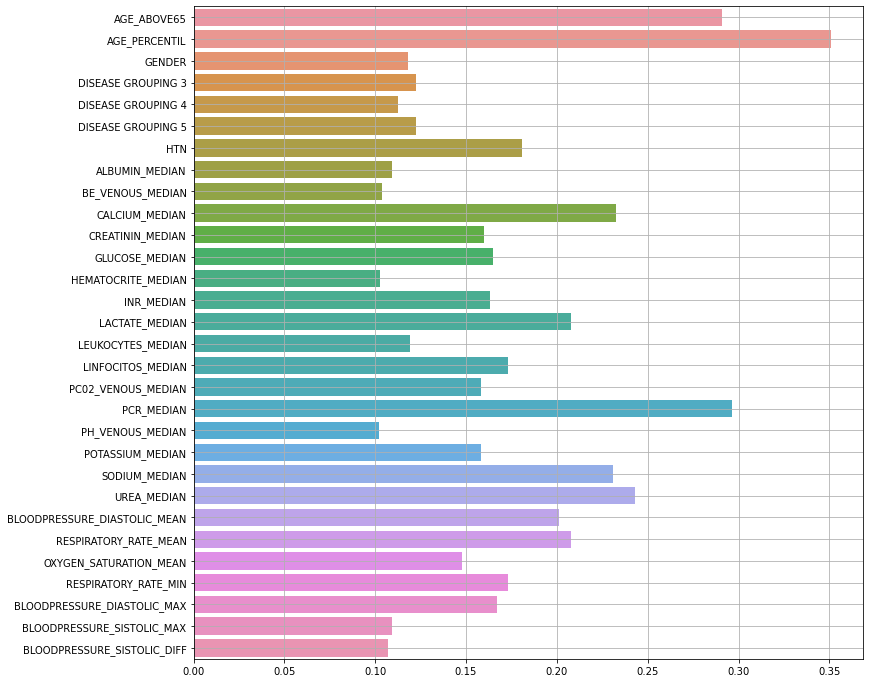

In [123]:
# gráfico com as correlações
importantes = dados_correlacionados_ICU.drop(['PATIENT_VISIT_IDENTIFIER' ,'ICU', 'WINDOW'], axis=1).apply(lambda x: x.corr(dados_correlacionados_ICU.ICU))
importantes = abs(importantes)
importantes
plt.figure(figsize = (12,12))
sns.barplot(x = importantes.values, y = importantes.index)
plt.grid()
plt.show()

# TREINAMENTO E AVALIAÇÃO DOS MODELOS  - SEGUNDA ABORDAGEM (CORRELAÇÃO ACIMA DE 0.1)

In [124]:
acuracia_logistic_regression_dois = roda_modelo_repeat_cv(modelo_logistic_regression, dados_correlacionados_ICU, 5, 10)

AUC médio: 0.7736067691495324
Desvio-padrão médio: 0.05572304976636146
Intervalo de confiança da acurácia: 0.6621606696168095 à 0.8850528686822553


In [125]:
acuracia_decision_tree_dois = roda_modelo_repeat_cv(modelo_decision_tree, dados_correlacionados_ICU, 5, 10)

AUC médio: 0.6531054679080995
Desvio-padrão médio: 0.05868975735192152
Intervalo de confiança da acurácia: 0.5357259532042565 à 0.7704849826119425


In [126]:
acuracia_svc_dois = roda_modelo_repeat_cv(modelo_svc, dados_correlacionados_ICU, 5, 10)

AUC médio: 0.5962592002888055
Desvio-padrão médio: 0.091354128997537
Intervalo de confiança da acurácia: 0.4135509422937315 à 0.7789674582838795


In [127]:
acuracia_random_forest_dois = roda_modelo_repeat_cv(modelo_random_forest, dados_correlacionados_ICU, 5, 10)

AUC médio: 0.8130083934113539
Desvio-padrão médio: 0.039658186866146854
Intervalo de confiança da acurácia: 0.7336920196790602 à 0.8923247671436476


In [128]:
acuracia_knn_dois = roda_modelo_repeat_cv(modelo_knn, dados_correlacionados_ICU, 5, 10)

AUC médio: 0.582925786133023
Desvio-padrão médio: 0.06371521431201518
Intervalo de confiança da acurácia: 0.45549535750899267 à 0.7103562147570535


# COMPARANDO A ACURÁCIA

In [129]:
# Series com a acurácia dos modelos utilizando os dados na primeira abordagem
um = pd.Series([acuracia_decision_tree, acuracia_knn, acuracia_logistic_regression,
                                    acuracia_random_forest, acuracia_svc])

In [130]:
# Series com a acurácia dos modelos utilizando os dados na segunda abordagem
dois = pd.Series([acuracia_decision_tree_dois, acuracia_knn_dois, acuracia_logistic_regression_dois,
                                    acuracia_random_forest_dois, acuracia_svc_dois])

In [131]:
# dataframe com as acurácias de cada modelo em cada abordagens
df_acuracia_modelos = pd.DataFrame()
df_acuracia_modelos['abord_um'] = [acuracia_decision_tree, acuracia_knn, acuracia_logistic_regression,
                                    acuracia_random_forest, acuracia_svc] 
df_acuracia_modelos['abord_dois'] = [acuracia_decision_tree_dois, acuracia_knn_dois, acuracia_logistic_regression_dois,
                                    acuracia_random_forest_dois, acuracia_svc_dois]
df_acuracia_modelos.index = ['DecisionTree', 'KNN', 'LogisticRegression', 'RandomForest', 'SVC']

Podemos considerar, nesse caso, modelos com bom desempenho os que atingiram 0.75 ou mais em sua acurácia na predição. Vejamos quais atingiram esse valor e em qual abordagem:

In [132]:
df_acuracia_modelos.style.applymap(cor_df).set_properties(**{'border-color': 'black','border-width':'thin','border-style':'dotted'})

,abord_um,abord_dois
DecisionTree,0.634516,0.653105
KNN,0.522191,0.582926
LogisticRegression,0.761241,0.773607
RandomForest,0.805289,0.813008
SVC,0.559077,0.596259


Os modelos RandomForestClassifier e LogisticRegression conseguiram acurácia acima de 0.75.

E quais conseguiram o pior e o melhor desempenho em cada abordagem?

In [133]:
# valor máximo e mínimo de cada abordagem
df_acuracia_modelos.style.highlight_min(color = 'red', axis = 0).highlight_max(color = 'green', axis = 0).set_properties(**{'border-color': 'black',
                                                                                                                            'border-width':'thin',
                                                                                                                            'border-style':'dotted'})

,abord_um,abord_dois
DecisionTree,0.634516,0.653105
KNN,0.522191,0.582926
LogisticRegression,0.761241,0.773607
RandomForest,0.805289,0.813008
SVC,0.559077,0.596259


O dataframe acima mostra que houve, em cada abordagem, um modelo com desempenho pior. Na primeira e na segunda abordagem o modelo KNN mostrou-se abaixo dos demais. 

O melhor desempenho nas duas abordagens pertence ao modelo RandomForestClassifier, tendo, na segunda abordagem, 0.01 de acurácia acima da primeira.

# CONCLUSÃO

Após muitas análises em torno dos dados dos pacientes que chegaram ao hospital, escolhemos como melhor abordagem a que utiliza os dados com correlação com a coluna ICU acima de 0.1 para ajuste dos modelos, embora a diferença em relação aos dados sem essa análise seja pequena.

Tivemos melhor desempenho com o modelo RandomForestClassifier(), ultrapassando 81% de acurácia em relação à classificação de pacientes que foram ou não para a UTI, sem nenhum tipo de otimização no modelo.